# Exercise 3
## Spam Classification
### Context
The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

### Content
The files contain one message per line. Each line is composed by two columns: v1 contains the label (ham or spam) and v2 contains the raw text.

This corpus has been collected from free or free for research sources at the Internet:

- A collection of 425 SMS spam messages was manually extracted from the Grumbletext Web site. This is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received. The identification of the text of spam messages in the claims is a very hard and time-consuming task, and it involved carefully scanning hundreds of web pages. The Grumbletext Web site is: [Web Link](http://www.grumbletext.co.uk/).
- A subset of 3,375 SMS randomly chosen ham messages of the NUS SMS Corpus (NSC), which is a dataset of about 10,000 legitimate messages collected for research at the Department of Computer Science at the National University of Singapore. The messages largely originate from Singaporeans and mostly from students attending the University. These messages were collected from volunteers who were made aware that their contributions were going to be made publicly available. The NUS SMS Corpus is avalaible at: [Web Link](http://www.comp.nus.edu.sg/~rpnlpir/downloads/corpora/smsCorpus/).
- A list of 450 SMS ham messages collected from Caroline Tag's PhD Thesis available at [Web Link](http://etheses.bham.ac.uk/253/1/Tagg09PhD.pdf).
- Finally, we have incorporated the SMS Spam Corpus v.0.1 Big. It has 1,002 SMS ham messages and 322 spam messages and it is public available at: [Web Link](http://www.esp.uem.es/jmgomez/smsspamcorpus/). This corpus has been used in the following academic researches:

Acknowledgements
The original dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection). The creators would like to note that in case you find the dataset useful, please make a reference to previous paper and the web page: http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/ in your papers, research, etc.

We offer a comprehensive study of this corpus in the following paper. This work presents a number of statistics, studies and baseline results for several machine learning methods.

Almeida, T.A., GÃ³mez Hidalgo, J.M., Yamakami, A. Contributions to the Study of SMS Spam Filtering: New Collection and Results. Proceedings of the 2011 ACM Symposium on Document Engineering (DOCENG'11), Mountain View, CA, USA, 2011.

In [1]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=a6becb91d4aca580e0b0eb2ed1e3df82456c23c09a0e3228147a49b5ae29f97f
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
import pandas as pd
import numpy as np
import wget
import os
from zipfile import ZipFile

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import string

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve

import gensim
from gensim.models import Word2Vec
import warnings


warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
try :
    from google.colab import files
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
    !unzip smsspamcollection.zip
    df = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
except ModuleNotFoundError :
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    path = os.getcwd()+'\Data'
    wget.download(url,path)
    temp=path+'\smsspamcollection.zip'
    file = ZipFile(temp)
    file.extractall(path)
    file.close()
    df = pd.read_csv(path + '\SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])

--2024-09-22 14:56:36--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z     [  <=>               ] 198.65K   648KB/s    in 0.3s    

2024-09-22 14:56:37 (648 KB/s) - ‘smsspamcollection.zip’ saved [203415]

Archive:  smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


In [4]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
display(df.shape) #Number of rows (instances) and columns in the dataset
df["target"].value_counts()/df.shape[0] #Class distribution in the dataset

(5572, 2)

,count
target,
ham,0.865937
spam,0.134063


In [6]:
X = df['text']
y = df['target'].map({'ham':0, 'spam':1})

In [7]:
# split data into training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = df['target'], test_size = 0.3, random_state = 18)

Preprocess the text data by removing stop words, converting all text to lowercase, and removing punctuation using NLTK package.


In [8]:
stop_words = set(stopwords.words('english'))
def preprocess(text):
    text = text.lower()
    text = ''.join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

In [27]:
X_train.head()

,text
5453,except theres chick huge boobs
2881,last chance claim ur £150 worth discount vouch...
3376,
2591,lol take member said aunt flow didnt visit 6 m...
3188,howz persons story


Train a Word2Vec model on the preprocessed training data using Gensim package.

In [28]:
sentences = [sentence.split() for sentence in X_train]
model = Word2Vec(sentences, vector_size=100, window=5, negative=20, min_count=1, workers=4)  #min_count establece el número mínimo de apariciones que una palabra debe tener en el corpus para ser incluida en el entrenamiento.

In [29]:
sentences[0]

['except', 'theres', 'chick', 'huge', 'boobs']

Convert the preprocessed text data to a vector representation using the Word2Vec model.

In [30]:
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [model.wv[word] for word in words if word in model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0) #convierte cada oración en en un vector promedio de las palabras presentes en esa oración.

X_train_w = np.array([vectorize(sentence) for sentence in X_train])
X_test_w = np.array([vectorize(sentence) for sentence in X_test])

Train a classification model such as logistic regression, random forests, or support vector machines using the vectorised training data and the sentiment labels.

In [31]:
clf = LogisticRegression()
clf.fit(X_train_w, y_train)

LogisticRegression()

Evaluate the performance of the classification model on the testing set with the accuracy, precision, recall and F1 score.

In [32]:
y_pred = clf.predict(X_test_w)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('AUC:', auc(fpr, tpr))

Accuracy: 0.8660287081339713
AUC: 0.5


# Excercise 3.1

Remove stopwords, then predict target using CountVectorizer.

use Random Forest classifier

In [33]:
# split data into training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = df['target'], test_size = 0.3, random_state = 18)

In [34]:
stop_words = set(stopwords.words('english'))
def preprocess(text):
    text = text.lower()
    text = ''.join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

X_train_cv = vectorizer.fit_transform(X_train)
X_test_cv = vectorizer.transform(X_test)

In [50]:
#Random Forest
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_cv, y_train)

# Predicción en test
y_pred_rf = rf_classifier.predict(X_test_cv)

In [51]:
# Desempeño
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)

print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print('AUC:', auc(fpr, tpr))

Accuracy: 0.9647129186602871
AUC: 0.8683035714285714


Utilizando CountVectorizer con Random Forest se obtiene un mejor desempeño que con el ejercicio de Work2Vec con regresión logística.

# Excercise 3.2

Predict target using TdidfVectorizer.

use Random Forest classifier

In [56]:
# split data into training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = df['target'], test_size = 0.3, random_state = 18)

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [54]:
# Random Forest
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_tfidf, y_train)

# Prediction on test data
y_pred_rf = rf_classifier.predict(X_test_tfidf)

In [59]:
# Performance evaluation
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)

print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print('AUC:', auc(fpr, tpr))

Accuracy: 0.9688995215311005
AUC: 0.8839285714285714


Manteniendo el modelo Random Forest, se obtiene un mejor desempeño utilizando TdidfVectorizer que CountVectorizer.

# Excercise 3.3

Predict target using CountVectorizer or TfideVectorizer.

choose any classification model and justify why

In [58]:
# split data into training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = df['target'], test_size = 0.3, random_state = 18)

In [59]:
stop_words = set(stopwords.words('english'))
def preprocess(text):
    text = text.lower()
    text = ''.join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

In [62]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [66]:
# Logistic Regression
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train_tfidf, y_train)

# Predicción
y_pred_lr = lr_classifier.predict(X_test_tfidf)
# Performance evaluation
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lr)

print('Accuracy:', accuracy_score(y_test, y_pred_lr))
print('AUC:', auc(fpr, tpr))

Accuracy: 0.9479665071770335
AUC: 0.8171246053670087


In [69]:
from sklearn.svm import SVC

svm_classifier = SVC(kernel='linear')

#Entrenamiento del modelo
svm_classifier.fit(X_train_tfidf, y_train)

# Predicción
y_pred_svm = svm_classifier.predict(X_test_tfidf)

# Desempeño
fpr, tpr, thresholds = roc_curve(y_test, y_pred_svm)

print('Accuracy:', accuracy_score(y_test, y_pred_svm))
print('AUC:', auc(fpr, tpr))

Accuracy: 0.9766746411483254
AUC: 0.9223806235201263


Se usa TfideVectorizer ya que dió mejores resultados en el ejericio 3.2

**Justificación de elección de los modelos:** Se ejecutó el proceso con Regresión Logística y SVM ya que son otros modelos diferentes al ramdom forest que se pueden usar en problemas de clasificación y son efectivos al trabajar con datos de alta dimensionalidad.

En la comparación del Accuracy y el AUC, se puede observar que el mejor desempeño se obtiene con el modelo SVM.

# Excercise 3.4

Increase and decrece the parameters values vector_size, window and negative then predict the target.

Plot the different values of the parameters with the performance of the model.

Use a Random Forest classifier and classification model of your choice and justify why.

Random Forest classifier:

parameter variation: `vector_size`

In [10]:
def vectorize(sentence,vector_size):
    words = sentence.split()
    words_vecs = [model.wv[word] for word in words if word in model.wv]
    if len(words_vecs) == 0:
        return np.zeros(vector_size)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0) #convierte cada oración en un vector promedio de las palabras presentes en esa oración.

In [26]:
accuracy_scores = []
auc_scores = []
vector_sizes = [20, 50, 100, 150, 200,250]

for vector_size in vector_sizes:
    sentences = [sentence.split() for sentence in X_train]
    model = Word2Vec(sentences, vector_size=vector_size, window=5, negative=20, min_count=1, workers=4)

    X_train_w = np.array([vectorize(sentence,vector_size) for sentence in X_train])
    X_test_w = np.array([vectorize(sentence,vector_size) for sentence in X_test])

    clf = RandomForestClassifier()
    clf.fit(X_train_w, y_train)

    y_pred = clf.predict(X_test_w)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    auc_scores.append(auc(fpr, tpr))

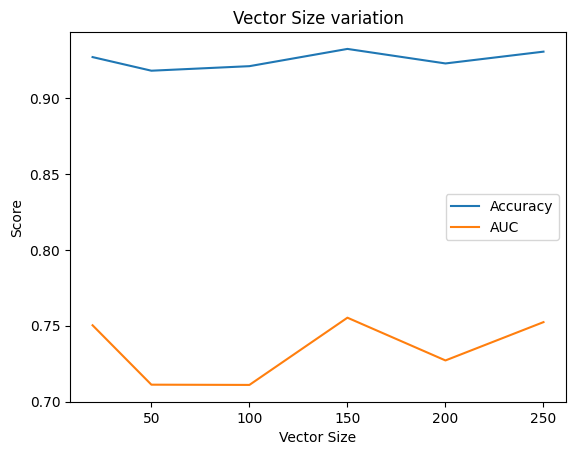

In [28]:
import matplotlib.pyplot as plt

plt.plot(vector_sizes, accuracy_scores, label='Accuracy')
plt.plot(vector_sizes, auc_scores, label='AUC')
plt.xlabel('Vector Size')
plt.ylabel('Score')
plt.title('Vector Size variation')
plt.legend()
plt.show()

In [29]:
data = {'Vector Size': vector_sizes, 'Accuracy': accuracy_scores, 'AUC': auc_scores}
df_results = pd.DataFrame(data)
print(df_results)

   Vector Size  Accuracy       AUC
0           20  0.927033  0.750321
1           50  0.918062  0.711178
2          100  0.921053  0.711018
3          150  0.932416  0.755315
4          200  0.922847  0.727148
5          250  0.930622  0.752392


Se observa que la variación del tamaño del vector afecta levemente el rendimiento, obtiendo el mejor desemepeño cuando el vector_size es igual a 150.

parameter variation: `window`

In [38]:
accuracy_scores = []
auc_scores = []
windows = [1, 3, 5, 7, 9, 11]

for window in windows:
    sentences = [sentence.split() for sentence in X_train]
    model = Word2Vec(sentences, vector_size=100, window=window, negative=20, min_count=1, workers=4)

    X_train_w = np.array([vectorize(sentence,100) for sentence in X_train])
    X_test_w = np.array([vectorize(sentence,100) for sentence in X_test])

    clf = RandomForestClassifier()
    clf.fit(X_train_w, y_train)

    y_pred = clf.predict(X_test_w)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    auc_scores.append(auc(fpr, tpr))

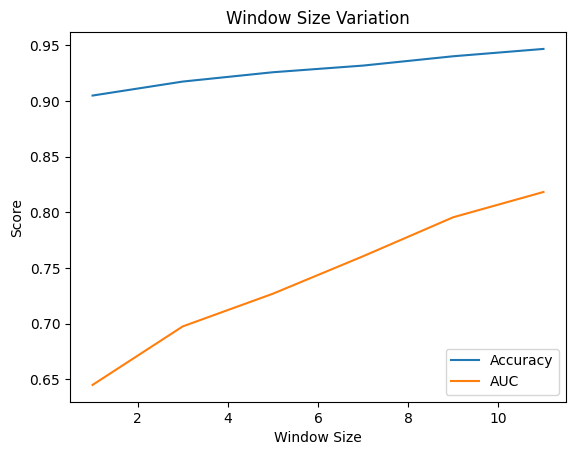

   Window Size  Accuracy       AUC
0            1  0.904904  0.645089
1            3  0.917464  0.697625
2            5  0.925837  0.726988
3            7  0.931818  0.760630
4            9  0.940191  0.795654
5           11  0.946770  0.818321


In [39]:
plt.plot(windows, accuracy_scores, label='Accuracy')
plt.plot(windows, auc_scores, label='AUC')
plt.xlabel('Window Size')
plt.ylabel('Score')
plt.title('Window Size Variation')
plt.legend()
plt.show()

data = {'Window Size': windows, 'Accuracy': accuracy_scores, 'AUC': auc_scores}
df_results = pd.DataFrame(data)
print(df_results)

Se observa que la variación del tamaño de la venta afecta el rendimiento, obtiendo un mejor desemepeño cuando el parámetro window se sube a 11.

parameter variation: `negative`

In [40]:
accuracy_scores = []
auc_scores = []
negatives = [10, 15, 20, 25, 30, 50]

for negative in negatives:
    sentences = [sentence.split() for sentence in X_train]
    model = Word2Vec(sentences, vector_size=100, window=5, negative=negative, min_count=1, workers=4)

    X_train_w = np.array([vectorize(sentence,100) for sentence in X_train])
    X_test_w = np.array([vectorize(sentence,100) for sentence in X_test])

    clf = RandomForestClassifier()
    clf.fit(X_train_w, y_train)

    y_pred = clf.predict(X_test_w)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    auc_scores.append(auc(fpr, tpr))

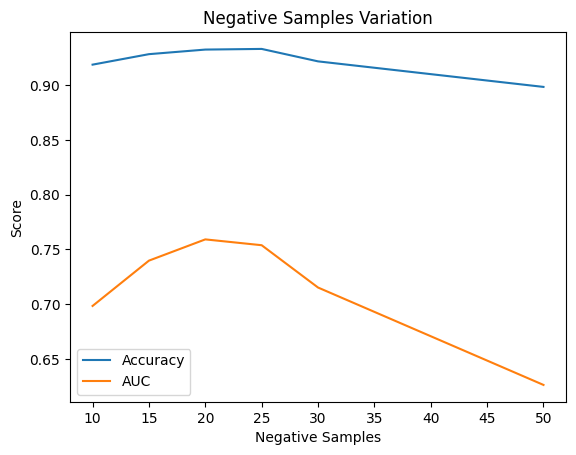

   Negative Samples  Accuracy       AUC
0                10  0.918660  0.698315
1                15  0.928230  0.739690
2                20  0.932416  0.759089
3                25  0.933014  0.753774
4                30  0.921651  0.715137
5                50  0.898325  0.626196


In [41]:
plt.plot(negatives, accuracy_scores, label='Accuracy')
plt.plot(negatives, auc_scores, label='AUC')
plt.xlabel('Negative Samples')
plt.ylabel('Score')
plt.title('Negative Samples Variation')
plt.legend()
plt.show()

data = {'Negative Samples': negatives, 'Accuracy': accuracy_scores, 'AUC': auc_scores}
df_results = pd.DataFrame(data)
print(df_results)

Se observa que el mejor desempeño se obtiene cuando el parámetro negative sampling está entre 20 y 25.

Running best parameters `vector_size, window and negative` (All at the same time)

In [42]:
sentences = [sentence.split() for sentence in X_train]
model = Word2Vec(sentences, vector_size=250, window=11, negative=20, min_count=1, workers=4)

X_train_w = np.array([vectorize(sentence,250) for sentence in X_train])
X_test_w = np.array([vectorize(sentence,250) for sentence in X_test])

clf = RandomForestClassifier()
clf.fit(X_train_w, y_train)

y_pred = clf.predict(X_test_w)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('AUC:', auc(fpr, tpr))

Accuracy: 0.94377990430622
AUC: 0.8147074782951855


Entrenando un modelo de Random Forest con los méjores parámetros encontrados en Word2Vec, se obtiene un accuracy de 0.94 y un auc de 0.81. Se puede observar que pese a que este desempeño es mejor que el random forest con los parámetros iniciales, sigue sin superar el random forest que se entrenó con data vectorizada con CountVectorizer y TfideVectorizer.

**XGBClassifier():** Se repite el proceso de variación de parámetros de Word2Vec, en esta ocasión con XGBClassifier() ya que se identificó que es un modelo no lineal más sensible a captar las variaciones en los embeddings de Word2Vec. (Modelos lineales como Logistic Regresion y SVM con Kernel lineal, fueron probados pero presentaron dificultades para capturar las variaciones de word2Vec, resultando en valores de accuracy y AUC muy similares)

parameter variation: vector_size

In [72]:
from xgboost import XGBClassifier

In [73]:
accuracy_scores = []
auc_scores = []
vector_sizes = [20, 50, 100, 150, 200,250]

for vector_size in vector_sizes:
    sentences = [sentence.split() for sentence in X_train]
    model = Word2Vec(sentences, vector_size=vector_size, window=5, negative=20, min_count=1, workers=4)

    X_train_w = np.array([vectorize(sentence,vector_size) for sentence in X_train])
    X_test_w = np.array([vectorize(sentence,vector_size) for sentence in X_test])

    clf = XGBClassifier()
    clf.fit(X_train_w, y_train)

    y_pred = clf.predict(X_test_w)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    auc_scores.append(auc(fpr, tpr))

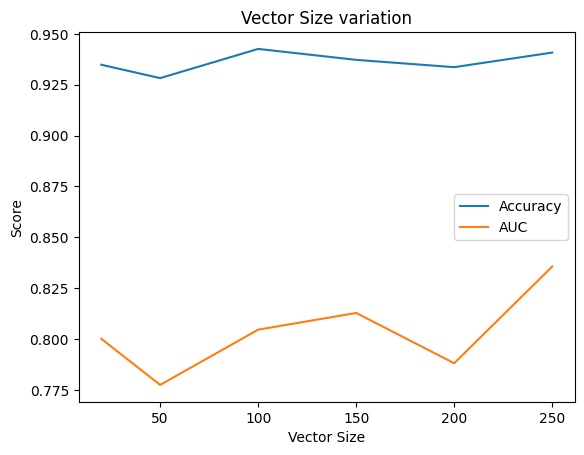

   Vector_size  Accuracy       AUC
0           20  0.934809  0.800094
1           50  0.928230  0.777427
2          100  0.942584  0.804583
3          150  0.937201  0.812796
4          200  0.933612  0.788082
5          250  0.940789  0.835623


In [75]:
plt.plot(vector_sizes, accuracy_scores, label='Accuracy')
plt.plot(vector_sizes, auc_scores, label='AUC')
plt.xlabel('Vector Size')
plt.ylabel('Score')
plt.title('Vector Size variation')
plt.legend()
plt.show()

data = {'Vector_size': vector_sizes, 'Accuracy': accuracy_scores, 'AUC': auc_scores}
df_results = pd.DataFrame(data)
print(df_results)

parameter variation: window

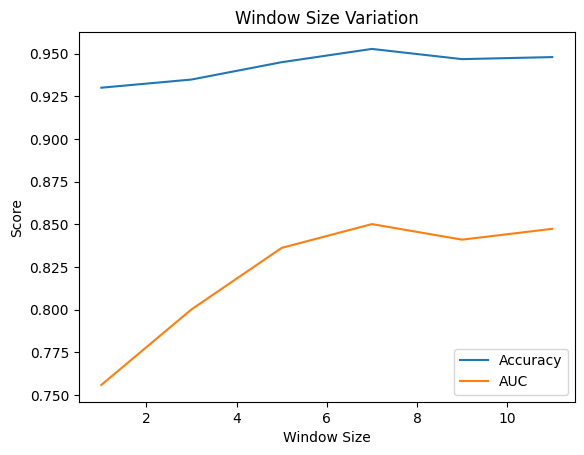

   Window Size  Accuracy       AUC
0            1  0.930024  0.755821
1            3  0.934809  0.800094
2            5  0.944976  0.836153
3            7  0.952751  0.850076
4            9  0.946770  0.840963
5           11  0.947967  0.847314


In [76]:
accuracy_scores = []
auc_scores = []
windows = [1, 3, 5, 7, 9, 11]

for window in windows:
    sentences = [sentence.split() for sentence in X_train]
    model = Word2Vec(sentences, vector_size=250, window=window, negative=20, min_count=1, workers=4)

    X_train_w = np.array([vectorize(sentence,250) for sentence in X_train])
    X_test_w = np.array([vectorize(sentence,250) for sentence in X_test])

    clf = XGBClassifier()
    clf.fit(X_train_w, y_train)

    y_pred = clf.predict(X_test_w)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    auc_scores.append(auc(fpr, tpr))

plt.plot(windows, accuracy_scores, label='Accuracy')
plt.plot(windows, auc_scores, label='AUC')
plt.xlabel('Window Size')
plt.ylabel('Score')
plt.title('Window Size Variation')
plt.legend()
plt.show()

data = {'Window Size': windows, 'Accuracy': accuracy_scores, 'AUC': auc_scores}
df_results = pd.DataFrame(data)
print(df_results)

parameter variation: negative

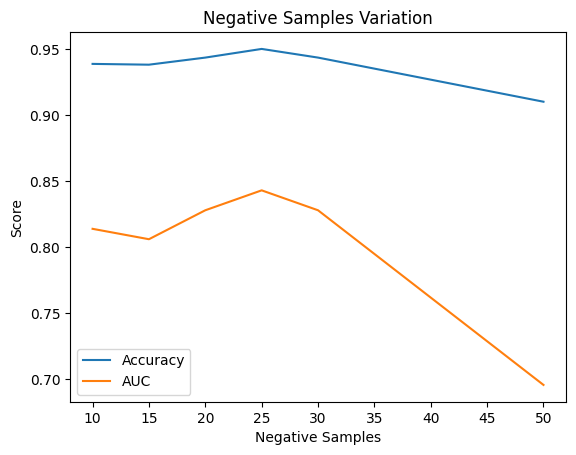

   Negative Samples  Accuracy       AUC
0                10  0.938995  0.813832
1                15  0.938397  0.805939
2                20  0.943780  0.827915
3                25  0.950359  0.843035
4                30  0.943780  0.827915
5                50  0.910287  0.695368


In [77]:
accuracy_scores = []
auc_scores = []
negatives = [10, 15, 20, 25, 30, 50]

for negative in negatives:
    sentences = [sentence.split() for sentence in X_train]
    model = Word2Vec(sentences, vector_size=250, window=5, negative=negative, min_count=1, workers=4)

    X_train_w = np.array([vectorize(sentence,250) for sentence in X_train])
    X_test_w = np.array([vectorize(sentence,250) for sentence in X_test])

    clf = XGBClassifier()
    clf.fit(X_train_w, y_train)

    y_pred = clf.predict(X_test_w)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    auc_scores.append(auc(fpr, tpr))

plt.plot(negatives, accuracy_scores, label='Accuracy')
plt.plot(negatives, auc_scores, label='AUC')
plt.xlabel('Negative Samples')
plt.ylabel('Score')
plt.title('Negative Samples Variation')
plt.legend()
plt.show()

data = {'Negative Samples': negatives, 'Accuracy': accuracy_scores, 'AUC': auc_scores}
df_results = pd.DataFrame(data)
print(df_results)

Running best parameters vector_size, window and negative (All at the same time)

In [79]:
import numpy as np
sentences = [sentence.split() for sentence in X_train]
model = Word2Vec(sentences, vector_size=250, window=11, negative=25, min_count=1, workers=4)

X_train_w = np.array([vectorize(sentence, 250) for sentence in X_train])
X_test_w = np.array([vectorize(sentence, 250) for sentence in X_test])

clf = XGBClassifier()
clf.fit(X_train_w, y_train)

y_pred = clf.predict(X_test_w)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('AUC:', auc(fpr, tpr))

Accuracy: 0.9521531100478469
AUC: 0.8478443172849249


Con XGboost y los méjores parámetros encontrados en Word2Vec, se obtiene un accuracy de 0.95 y un auc de 0.84. Estos valores, aunque demuestran un mejor desempeño que el random forest y sus méjores parámetros encontrados en Word2Vec, siguen sin superar los modelos entrenados con con data vectorizada con CountVectorizer y TfideVectorizer.

Se puede concluir que para este caso, las técnicas de vectorización CountVectorizer y TfideVectorizer proporcionaron mejores modelos que aquellos entrenados con data vectorizada con Word2Vec.